In [61]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
def derivativa_sigmoid(x):
    return x * (1 - x)

class expert():
    
    def __init__(self,n_input,n_hidden,n_output):
        self.W1 = np.random.normal(0,1/np.sqrt(2),size=[n_hidden,n_input])
        self.W2 = np.random.normal(0,1/np.sqrt(2),size=[n_output,n_hidden])
        self.b1 = np.zeros((n_hidden,1))
        self.b2 = np.zeros((n_output,1))
    
    def train(self, max_epoch, lerning_rate, X, y):
        #m represent o numero de samples
        m = X.shape[0]

        eqm = []
        for epoch in range(1,max_epoch):
            #calcula feed forward
            z1 = np.dot(self.W1,X.T)+self.b1 
            a1 = sigmoid(z1)
            z2 = np.dot(self.W2,a1)+self.b2  #Shape1,4
            a2 = sigmoid(z2)   #Shape1,4
            
            #calcula erro
            erro = np.subtract(a2,y.T)
            #Calcula eqm e append no vetor
            _eqm =  1.0/len(y) * np.sum(np.sum(np.square(erro), axis=0))
            eqm.append(_eqm)
            
            #BACK PROPAGATION
            dz2 = a2-y.T  #SHAPE 1,4 ---- out-target
        #     print('dz2',dz2)
            dW2 = np.dot(dz2,a1.T)/m #SHAPE 1,2  
        #     print('dW2',dW2)
            db2 = np.sum(dz2,axis=1,keepdims=True)/m
        #     print('db2',db2)
            dz1 = np.multiply(np.dot(self.W2.T,dz2),derivativa_sigmoid(z1))  #SHAPE 2,4
        #     print('dz1',dz1)
            dW1 = np.dot(dz1,X)/m #SHAPE 2,2
        #     print('dW1',dW1)
            db1 = np.sum(dz1,axis=1,keepdims=True)/m
        #     print('db1',db1)
            
            #atualiza pesos
            self.W2 = self.W2 - learning_rate*dW2
            self.W1 = self.W1 - learning_rate*dW1
            self.b2 = self.b2 - learning_rate*db2
            self.b1 = self.b1 - learning_rate*db1
        
        import matplotlib.pyplot as plt
        plt.plot(eqm)
        plt.show()
            

        

In [62]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
# Create the training data for XOR.
data = np.array([[0,0,0],[1,0,1],[1,1,0],[0,1,1]])
#First two columns are the inputs,3rd Column consists of the labels
Y_train = data[:,2].reshape(data.shape[0],1)
X_train = data[:,:2]

X = X_train
y = Y_train
learning_rate = 0.05

In [64]:
X = X_train
y = Y_train

n_input = 2
n_hidden = 2
n_output=1
iterations = 1000

m = X.shape[0]# m is the number of training samples

learning_rate = 0.5

In [65]:
ep =expert(n_input,n_hidden,n_output)

/home/favoretti/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in multiply
  import sys


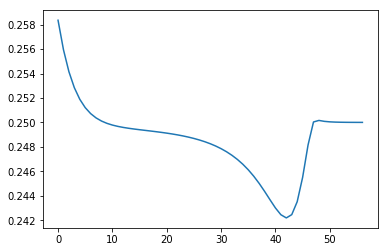

In [66]:
ep.train(2000, learning_rate, X, y)